In [3]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt

In [354]:
project_path = 'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101'

def join_path(relative_path: str) -> str:
    return os.path.join(project_path, relative_path)

def pickle_load(relative_path: str):  # -> pickled_file_contents
    return pickle.load(open(join_path(relative_path), 'rb'))

def pickle_save(obj: object, relative_path: str) -> None:
    pickle.dump(obj, open(join_path(relative_path), 'wb'))
    
rng = np.random.default_rng(seed=42)

In [6]:
elev_filt = pickle_load('Data\\Decomposed_Data\\elevation_filtered.pkl')
elev = pickle_load('Data\\Decomposed_Data\\elevation.pkl')

lste_filt = pickle_load('Data\\Decomposed_Data\\LSTE_filtered.pkl')
lste = pickle_load('Data\\Decomposed_Data\\LSTE.pkl')

ref_filt = pickle_load('Data\\Decomposed_Data\\reflectance_filtered.pkl')
ref = pickle_load('Data\\Decomposed_Data\\reflectance.pkl')

good_coords = pickle_load('Data\\Decomposed_Data\\good_coords.pkl')

x = pickle_load('Data\\Decomposed_Data\\x.pkl')
y = pickle_load('Data\\Decomposed_Data\\y.pkl')

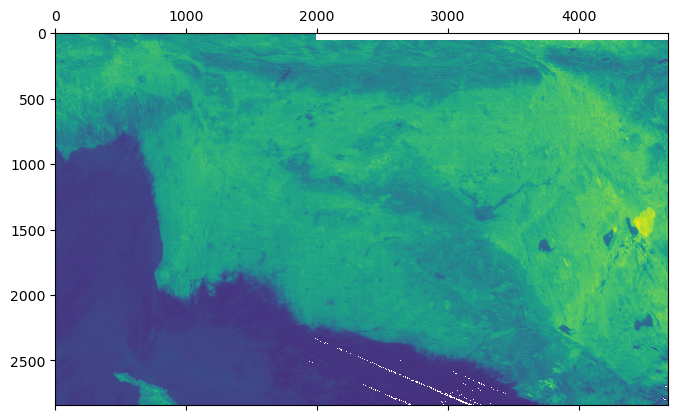

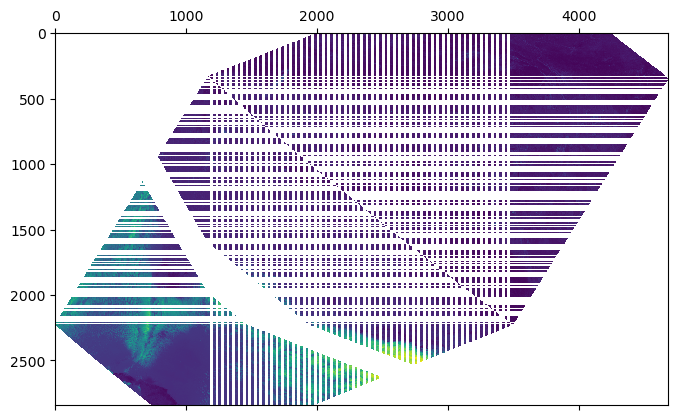

In [98]:
plt.matshow(lste[::-1,:])
plt.matshow(ref[::-1,:,0])

In [96]:
np.percentile(y, [.33,.66]), np.percentile(x, [.25,.5,.75])

(array([3690898.80214118, 3691453.07378233]),
 array([329676.4095239 , 330277.52087869, 330878.33551038]))

In [84]:
yfrac = []
num_good_coords = np.sum(good_coords)
for i in range(len(y)):
    yfrac.append(np.sum(good_coords[:i, :] / num_good_coords))

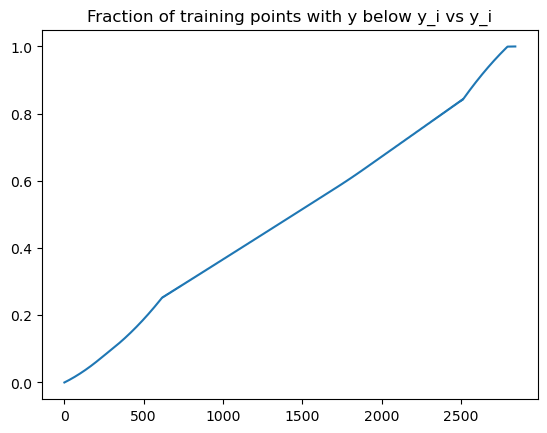

In [89]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, len(y)+1), yfrac)
ax.set_title('Fraction of training points with y below y_i vs y_i')
plt.show(fig)

In [78]:
xfrac = []
for j in range(len(x)):
    xfrac.append(np.sum(good_coords[:, :j] / num_good_coords))

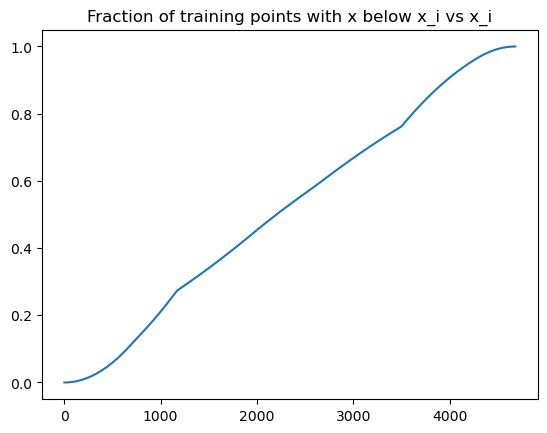

In [90]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, len(x)+1), xfrac)
ax.set_title('Fraction of training points with x below x_i vs x_i')
plt.show(fig)

In [289]:
indices = np.meshgrid(
    np.arange(len(y)), np.arange(len(x)), indexing='ij'
)
order = indices[0][::-1] + indices[1][::-1]

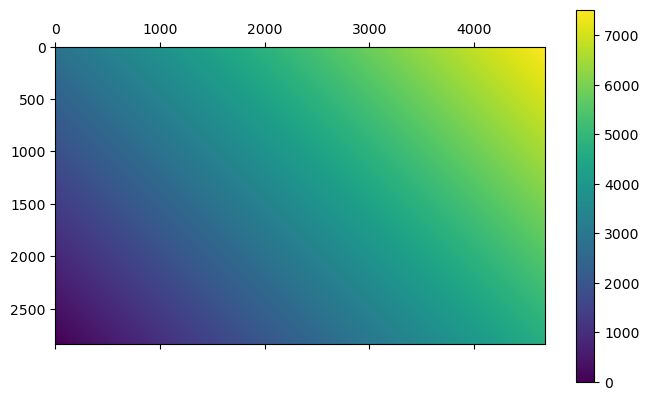

In [290]:
plt.matshow(order)
plt.colorbar()

In [308]:
thresholds = np.percentile(
    np.arange(num_good_coords),
    np.arange(5, 105, 5)
)

splits = np.zeros_like(good_coords) - 1
total_found = 0
cur_split = 0
cur_threshold = thresholds[cur_split]

done = False
for rank in np.arange(order.max() + 1, dtype=int):
    if done:
        break
    
    mask = order == rank
    
    y_indices = indices[0][mask]
    x_indices = indices[1][mask]
    
    for y_index, x_index in zip(y_indices, x_indices):
        if good_coords[y_index, x_index]:
            splits[y_index, x_index] = cur_split
            total_found += 1
            if total_found >= cur_threshold + 1:
                if cur_split == len(thresholds) - 1:
                    done = True
                    break
                else:
                    cur_split += 1
                    cur_threshold = thresholds[cur_split]

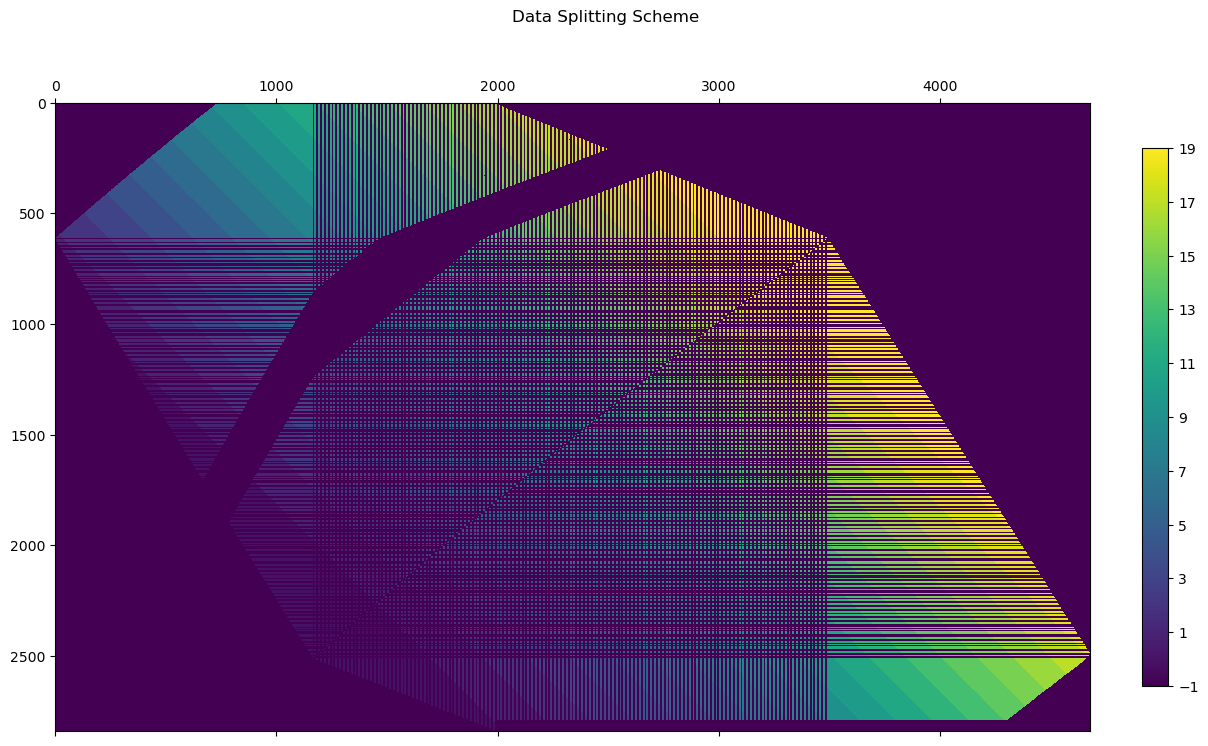

In [327]:
fig, ax = plt.subplots(figsize=(12,8), layout='constrained')
plt.imshow(splits)
ax.matshow(splits, cmap='viridis')
plt.colorbar(ticks=np.arange(-1, 20, 2), shrink=0.7)
fig.suptitle('Data Splitting Scheme')
plt.show(fig)

In [364]:
save_path = 'Data\\Split_Data\\(__)_(**).pkl'

pickle_list = [
    ('elevation', elev),
    ('reflectance', ref),
    ('LSTE', lste)
]

for split_num in np.arange(splits.max() + 1):
    split = splits == split_num
    split_str = f'{"0"*(2-len(str(split_num))) + str(split_num)}'
    save_path_num = save_path.replace('(**)', split_str)
    for name, data in pickle_list:
        save_path_name_num = save_path_num.replace('(__)', name)
        save_data = data[split]
        pickle_save(save_data, save_path_name_num)